Author: Naomi Baes and Chat GPT

# 3D plots

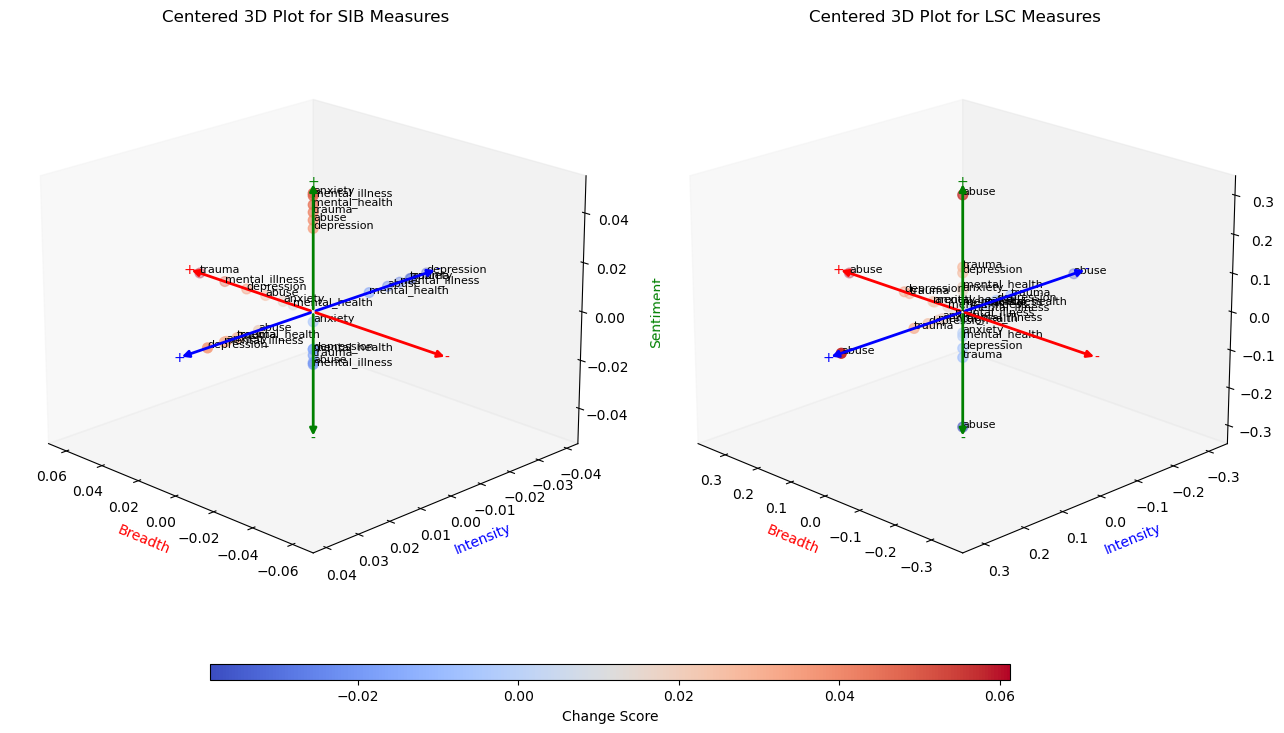

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# Load the data
df = pd.read_csv('../model_comparison/final_change_scores_all-year.csv')

# Assigning axes based on 'dimension'
df['x'] = df.apply(lambda row: row['change_score'] if row['dimension'] == 'Breadth' else 0, axis=1)  # Breadth on x-axis
df['y'] = df.apply(lambda row: row['change_score'] if row['dimension'] == 'Intensity' else 0, axis=1)  # Intensity on y-axis
df['z'] = df.apply(lambda row: row['change_score'] if row['dimension'] == 'Sentiment' else 0, axis=1)  # Sentiment on z-axis

def plot_3d_centered(ax, data, title):
    ax.view_init(elev=20, azim=135)  # Adjust the viewing angle

    # Scatter plot
    scatter = ax.scatter(data['x'], data['y'], data['z'], c=data['change_score'], cmap='coolwarm', s=50)

    # Dynamically adjust the range of the axes based on the data
    x_range = max(abs(data['x'].max()), abs(data['x'].min()))
    y_range = max(abs(data['y'].max()), abs(data['y'].min()))
    z_range = max(abs(data['z'].max()), abs(data['z'].min()))

    # Extend the range slightly to ensure arrows go beyond the last data point
    x_range_extended = x_range * 1.1
    y_range_extended = y_range * 1.1
    z_range_extended = z_range * 1.1

    # Arrows for positive and negative directions
    arrows = [
        Arrow3D([0, x_range_extended], [0, 0], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="red"),    # Breadth (x-axis)
        Arrow3D([0, -x_range_extended], [0, 0], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="red"),   # Negative Breadth
        Arrow3D([0, 0], [0, y_range_extended], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="blue"),   # Intensity (y-axis)
        Arrow3D([0, 0], [0, -y_range_extended], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="blue"),  # Negative Intensity
        Arrow3D([0, 0], [0, 0], [0, z_range_extended], mutation_scale=10, lw=2, arrowstyle="-|>", color="green"),  # Sentiment (z-axis)
        Arrow3D([0, 0], [0, 0], [0, -z_range_extended], mutation_scale=10, lw=2, arrowstyle="-|>", color="green")  # Negative Sentiment
    ]
    for arrow in arrows:
        ax.add_artist(arrow)

    # Add + and - labels at the ends of the poles
    ax.text(x_range_extended * 1.0, 0, 0, '+', color='red', ha='center', va='center')    # Breadth +
    ax.text(-x_range_extended * 1.0, 0, 0, '-', color='red', ha='center', va='center')   # Breadth -
    ax.text(0, y_range_extended * 1.0, 0, '+', color='blue', ha='center', va='center')   # Intensity +
    ax.text(0, -y_range_extended * 1.0, 0, '-', color='blue', ha='center', va='center')  # Intensity -
    ax.text(0, 0, z_range_extended * 1.0, '+', color='green', ha='center', va='center')  # Sentiment +
    ax.text(0, 0, -z_range_extended * 1.0, '-', color='green', ha='center', va='center')  # Sentiment -

    # Label the targets (data points)
    for i, row in data.iterrows():
        ax.text(row['x'], row['y'], row['z'], row['target'], color='black', fontsize=8)

    # Axes properties
    ax.set_xlabel('Breadth', color='red')      # Breadth on x-axis
    ax.set_ylabel('Intensity', color='blue')  # Intensity on y-axis
    ax.set_zlabel('Sentiment', color='green', labelpad=10)  # Sentiment on z-axis with padding
    ax.set_title(title, pad=0)  # Add padding to the title

    # Ensure axes intersect at (0, 0, 0)
    ax.set_xlim([-x_range_extended, x_range_extended])
    ax.set_ylim([-y_range_extended, y_range_extended])
    ax.set_zlim([-z_range_extended, z_range_extended])

    # Grid off
    ax.grid(False)

    return scatter  # Return scatter object for color bar

# Filter data for SIB and LSC
data_sib = df[df['measure'] == 'SIB']
data_lsc = df[df['measure'] == 'LSC']

# Create a single figure with two subplots side by side
fig = plt.figure(figsize=(16, 8))  # Wider figure to accommodate two plots

# First subplot for SIB
ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 columns, first plot
scatter1 = plot_3d_centered(ax1, data_sib, 'Centered 3D Plot for SIB Measures')

# Second subplot for LSC
ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 columns, second plot
scatter2 = plot_3d_centered(ax2, data_lsc, 'Centered 3D Plot for LSC Measures')

# Add a shared color bar underneath the plots
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # Position: [left, bottom, width, height]
cbar = fig.colorbar(scatter1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Change Score')

# Reduce space between subplots, legend, and titles
plt.subplots_adjust(wspace=0.1, bottom=0.1, top=0.9)  # Adjust the horizontal space, bottom, and top margins

plt.show()

## Plots grouped by 6 targets

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

# Load the data
df = pd.read_csv('../model_comparison/final_change_scores_all-year.csv')

# Filter data for SIB and LSC measures
df = df[df['measure'].isin(['SIB', 'LSC'])]

# Assigning axes based on 'dimension'
df['x'] = df.apply(lambda row: row['change_score'] if row['dimension'] == 'Breadth' else 0, axis=1)  # Breadth on x-axis
df['y'] = df.apply(lambda row: row['change_score'] if row['dimension'] == 'Intensity' else 0, axis=1)  # Intensity on y-axis
df['z'] = df.apply(lambda row: row['change_score'] if row['dimension'] == 'Sentiment' else 0, axis=1)  # Sentiment on z-axis

def plot_3d_centered(ax, data, target, measure):
    ax.view_init(elev=20, azim=135)  # Adjust the viewing angle

    # Scatter plot using raw scores
    scatter = ax.scatter(data['x'], data['y'], data['z'], c=data['change_score'], cmap='coolwarm', s=100)  # Increased size of points

    # Dynamically adjust the range of the axes based on the data
    x_range = max(abs(data['x'].max()), abs(data['x'].min()))
    y_range = max(abs(data['y'].max()), abs(data['y'].min()))
    z_range = max(abs(data['z'].max()), abs(data['z'].min()))

    # Extend the range slightly to ensure arrows go beyond the last data point
    x_range_extended = x_range * 1.4
    y_range_extended = y_range * 1.4
    z_range_extended = z_range * 1.4

    # Arrows for positive and negative directions
    arrows = [
        Arrow3D([0, x_range_extended], [0, 0], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="darkred"),    # Breadth (x-axis)
        Arrow3D([0, -x_range_extended], [0, 0], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="darkred"),   # Negative Breadth
        Arrow3D([0, 0], [0, y_range_extended], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="royalblue"),   # Intensity (y-axis)
        Arrow3D([0, 0], [0, -y_range_extended], [0, 0], mutation_scale=10, lw=2, arrowstyle="-|>", color="royalblue"),  # Negative Intensity
        Arrow3D([0, 0], [0, 0], [0, z_range_extended], mutation_scale=10, lw=2, arrowstyle="-|>", color="darkgreen"),  # Sentiment (z-axis)
        Arrow3D([0, 0], [0, 0], [0, -z_range_extended], mutation_scale=10, lw=2, arrowstyle="-|>", color="darkgreen")  # Negative Sentiment
    ]
    for arrow in arrows:
        ax.add_artist(arrow)

    # Add + and - labels at the ends of the poles
    ax.text(x_range_extended * 1.0, 0, 0, '+', color='darkred', ha='center', va='center', fontsize=12)    # Breadth +
    ax.text(-x_range_extended * 1.0, 0, 0, '-', color='darkred', ha='center', va='center', fontsize=12)   # Breadth -
    ax.text(0, y_range_extended * 1.0, 0, '+', color='royalblue', ha='center', va='center', fontsize=12)   # Intensity +
    ax.text(0, -y_range_extended * 1.0, 0, '-', color='royalblue', ha='center', va='center', fontsize=12)  # Intensity -
    ax.text(0, 0, z_range_extended * 1.0, '+', color='darkgreen', ha='center', va='center', fontsize=12)  # Sentiment +
    ax.text(0, 0, -z_range_extended * 1.0, '-', color='darkgreen', ha='center', va='center', fontsize=12)  # Sentiment -

    # Add the target and measure label inside the plot
    ax.text(0, 0, z_range_extended * 1.2, f'{target} ({measure})', color='black', ha='center', va='center', fontsize=14)

    # Axes properties
    ax.set_xlabel('Breadth', color='darkred', fontsize=12)      # Breadth on x-axis
    ax.set_ylabel('Intensity', color='royalblue', fontsize=12)  # Intensity on y-axis
    ax.set_zlabel('Sentiment', color='darkgreen', fontsize=12, labelpad=10)  # Sentiment on z-axis with padding

    # Ensure axes intersect at (0, 0, 0)
    ax.set_xlim([-x_range_extended, x_range_extended])
    ax.set_ylim([-y_range_extended, y_range_extended])
    ax.set_zlim([-z_range_extended, z_range_extended])

    # Grid off
    ax.grid(False)

    return scatter  # Return scatter object for color bar

# Group data by target
grouped_data = df.groupby('target')

# Create a figure for each target
for target, data in grouped_data:
    # Filter data for SIB and LSC measures for the current target
    data_sib = data[data['measure'] == 'SIB']
    data_lsc = data[data['measure'] == 'LSC']

    # Create a single figure with two subplots side by side
    fig = plt.figure(figsize=(16, 8))  # Wider figure to accommodate two plots

    # First subplot for SIB
    ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 columns, first plot
    scatter1 = plot_3d_centered(ax1, data_sib, target, 'SIB')

    # Second subplot for LSC
    ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 columns, second plot
    scatter2 = plot_3d_centered(ax2, data_lsc, target, 'LSC')

    # Add a shared color bar underneath the plots (moved closer to the plots)
    cbar_ax = fig.add_axes([0.16, 0.15, 0.3, 0.02])  # Position: [left, bottom, width, height] (increased bottom value)
    cbar = fig.colorbar(scatter1, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Change Score', fontsize=12)  # Increased font size

    # Use tight layout to minimize space between subplots, titles, and color bar
    plt.tight_layout(rect=[0, 0.15, 0.61, 0.7])  # Adjust the layout to make room for the color bar

    # Save the plot to a file
    filename = f'plot_bootstrap_{target}_change-score.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save with high resolution and tight bounding box
    plt.close()  # Close the figure to free up memory

C:\Users\naomi\AppData\Local\Temp\ipykernel_30320\2583755962.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 0.61, 0.7])  # Adjust the layout to make room for the color bar


# End of notebook